Training GAN on Sine Wave...
Epoch 0 | D Loss: 1.4061 | G Loss: 0.7669
Epoch 200 | D Loss: 1.4888 | G Loss: 0.7680
Epoch 400 | D Loss: 1.0681 | G Loss: 1.1574
Epoch 600 | D Loss: 0.9575 | G Loss: 1.2013
Epoch 800 | D Loss: 0.7218 | G Loss: 1.3651
Epoch 1000 | D Loss: 1.4281 | G Loss: 0.5517
Epoch 1200 | D Loss: 0.8470 | G Loss: 1.3686
Epoch 1400 | D Loss: 0.9271 | G Loss: 1.1688
Epoch 1600 | D Loss: 1.2032 | G Loss: 1.2141
Epoch 1800 | D Loss: 1.4029 | G Loss: 0.7373


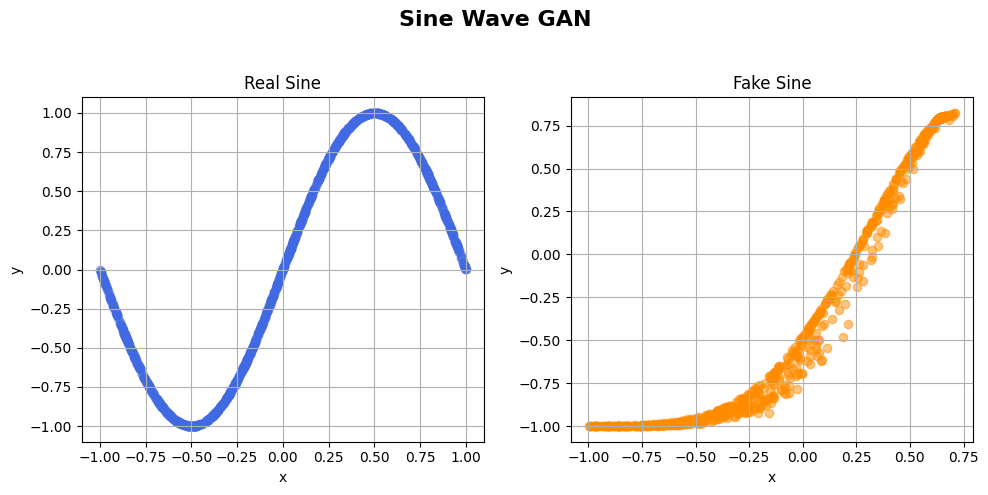

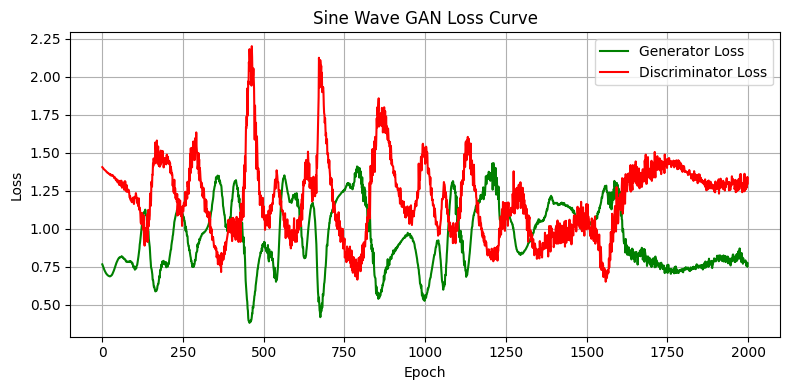

Training GAN on Parametric Curve (Original)...
Epoch 0 | D Loss: 1.4248 | G Loss: 0.8137
Epoch 200 | D Loss: 0.4194 | G Loss: 1.8547
Epoch 400 | D Loss: 1.2137 | G Loss: 0.9035
Epoch 600 | D Loss: 0.8790 | G Loss: 1.1951
Epoch 800 | D Loss: 0.9327 | G Loss: 1.0714
Epoch 1000 | D Loss: 1.3693 | G Loss: 0.7419
Epoch 1200 | D Loss: 1.2715 | G Loss: 0.7617
Epoch 1400 | D Loss: 1.3239 | G Loss: 0.7275
Epoch 1600 | D Loss: 1.3175 | G Loss: 0.7472
Epoch 1800 | D Loss: 1.3190 | G Loss: 0.7283
Training Modified GAN on Parametric Curve...
Epoch 0 | D Loss: 1.3864 | G Loss: 0.7679
Epoch 200 | D Loss: 0.9824 | G Loss: 1.1739
Epoch 400 | D Loss: 1.4818 | G Loss: 0.4985
Epoch 600 | D Loss: 1.4382 | G Loss: 0.6555
Epoch 800 | D Loss: 1.5805 | G Loss: 0.6121
Epoch 1000 | D Loss: 1.3252 | G Loss: 0.7372
Epoch 1200 | D Loss: 1.3573 | G Loss: 0.7536
Epoch 1400 | D Loss: 1.3769 | G Loss: 0.7205
Epoch 1600 | D Loss: 1.3499 | G Loss: 0.7071
Epoch 1800 | D Loss: 1.3479 | G Loss: 0.7437


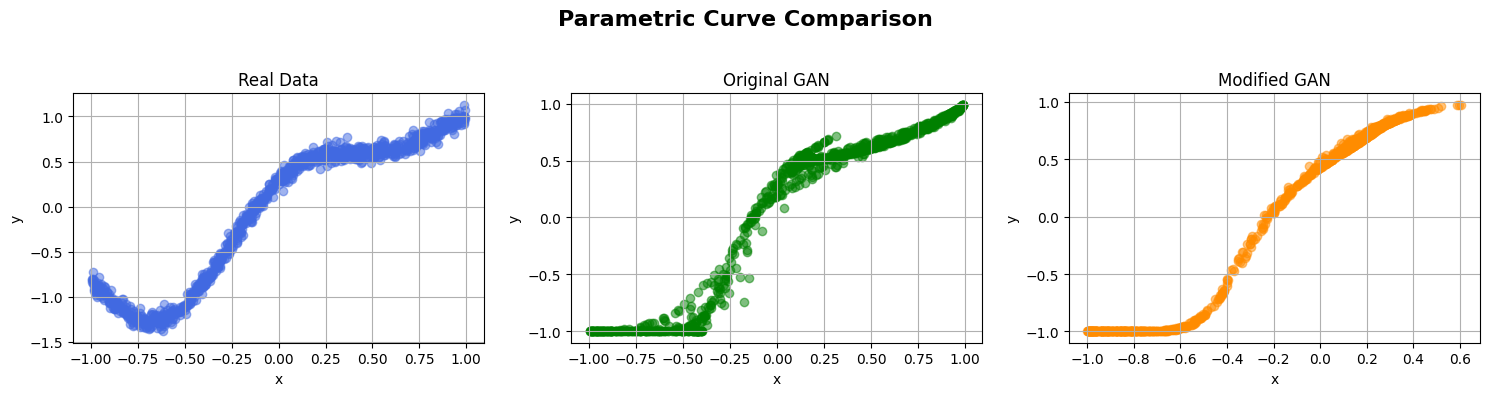

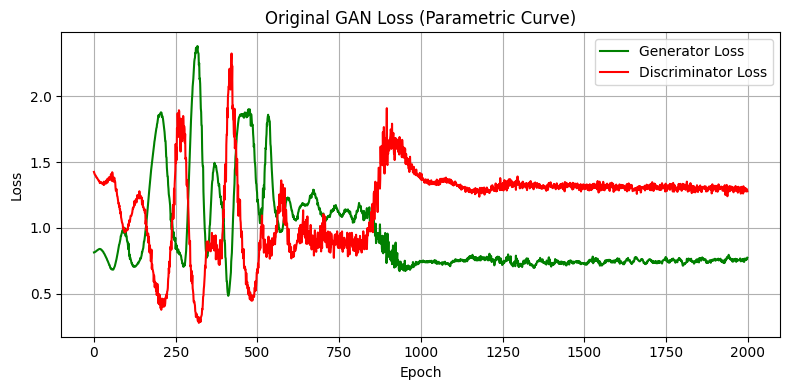

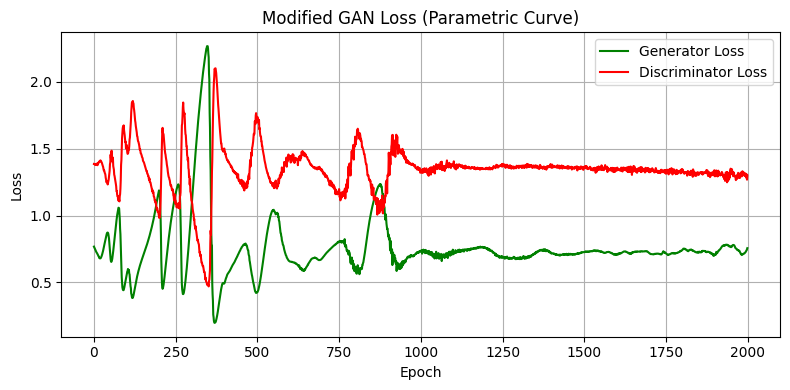

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create folders to save models and figures
os.makedirs("saved_models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Helper Plot Functions
def plot_samples(real, fake, title_real="Real", title_fake="Fake", main_title="Real vs. Fake Samples", filename=None):
    plt.figure(figsize=(10, 5))
    plt.suptitle(main_title, fontsize=16, fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.title(title_real)
    plt.scatter(real[:, 0], real[:, 1], alpha=0.5, color='royalblue')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title(title_fake)
    plt.scatter(fake[:, 0], fake[:, 1], alpha=0.5, color='darkorange')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

def plot_loss_curve(losses_g, losses_d, title="Loss Curve", filename=None):
    plt.figure(figsize=(8, 4))
    plt.plot(losses_g, label="Generator Loss", color='green')
    plt.plot(losses_d, label="Discriminator Loss", color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

def compare_gan_outputs(real, fake1, fake2, title1="Original GAN", title2="Modified GAN", main_title="GAN Output Comparison", filename=None):
    plt.figure(figsize=(15, 4))
    plt.suptitle(main_title, fontsize=16, fontweight='bold')

    plt.subplot(1, 3, 1)
    plt.title("Real Data")
    plt.scatter(real[:, 0], real[:, 1], alpha=0.5, color='royalblue')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.title(title1)
    plt.scatter(fake1[:, 0], fake1[:, 1], alpha=0.5, color='green')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.title(title2)
    plt.scatter(fake2[:, 0], fake2[:, 1], alpha=0.5, color='darkorange')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Synthetic Data Generators
def generate_sine_data(n_samples=1000):
    x = np.random.uniform(-1, 1, n_samples)
    y = np.sin(np.pi * x)
    return torch.tensor(np.stack((x, y), axis=1), dtype=torch.float32)

def generate_parametric_data(n_samples=1000, noise_std=0.05):
    x = np.random.uniform(-1, 1, n_samples)
    noise = np.random.normal(0, noise_std, size=n_samples)
    y = np.sin(2 * x) + 0.3 * np.cos(5 * x) + noise
    return torch.tensor(np.stack((x, y), axis=1), dtype=torch.float32)

# GAN Architectures
class Generator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Added for output scaling
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

class ModifiedGenerator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Training Function
def train_gan(G, D, data_fn, n_epochs=2000, batch_size=128, lr=0.001, print_every=200):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr)
    optimizer_D = optim.Adam(D.parameters(), lr=lr)
    loss_g, loss_d = [], []

    for epoch in range(n_epochs):
        real_samples = data_fn(batch_size).to(device)
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        z = torch.randn(batch_size, 2).to(device)
        fake_samples = G(z)

        # Discriminator training
        D_loss_real = criterion(D(real_samples), real_labels)
        D_loss_fake = criterion(D(fake_samples.detach()), fake_labels)
        D_loss = D_loss_real + D_loss_fake
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Generator training
        z = torch.randn(batch_size, 2).to(device)
        fake_samples = G(z)
        G_loss = criterion(D(fake_samples), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        loss_g.append(G_loss.item())
        loss_d.append(D_loss.item())

        if epoch % print_every == 0:
            print(f"Epoch {epoch} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

    return loss_g, loss_d


# Training and Plot Generation


# 1. GAN Task 1: Sine Wave
print("Training GAN on Sine Wave...")
G_sine, D_sine = Generator().to(device), Discriminator().to(device)
loss_g_sine, loss_d_sine = train_gan(G_sine, D_sine, generate_sine_data)
real_sine = generate_sine_data(1000)
with torch.no_grad():
    fake_sine = G_sine(torch.randn(1000, 2).to(device)).cpu()
plot_samples(real_sine, fake_sine, "Real Sine", "Fake Sine", "Sine Wave GAN", filename="figures/fig1_sine_wave.png")
plot_loss_curve(loss_g_sine, loss_d_sine, "Sine Wave GAN Loss Curve", filename="figures/fig2_sine_loss.png")
torch.save(G_sine.state_dict(), "saved_models/generator_sine.pth")

# 2. GAN Task 2: Parametric Curve (Original)
print("Training GAN on Parametric Curve (Original)...")
G_para, D_para = Generator().to(device), Discriminator().to(device)
loss_g1, loss_d1 = train_gan(G_para, D_para, generate_parametric_data)
with torch.no_grad():
    fake_para = G_para(torch.randn(1000, 2).to(device)).cpu()
torch.save(G_para.state_dict(), "saved_models/generator_parametric_original.pth")

# 3. GAN Task 3: Parametric Curve (Modified GAN)
print("Training Modified GAN on Parametric Curve...")
G_mod, D_mod = ModifiedGenerator().to(device), Discriminator().to(device)
loss_g2, loss_d2 = train_gan(G_mod, D_mod, generate_parametric_data)
with torch.no_grad():
    fake_mod = G_mod(torch.randn(1000, 2).to(device)).cpu()
torch.save(G_mod.state_dict(), "saved_models/generator_parametric_modified.pth")

# Compare Real, Original GAN, and Modified GAN
real_para = generate_parametric_data(1000)
compare_gan_outputs(real_para, fake_para, fake_mod, "Original GAN", "Modified GAN", "Parametric Curve Comparison", filename="figures/fig3_parametric_comparison.png")

# Loss Curve Visualizations for Parametric Curve
plot_loss_curve(loss_g1, loss_d1, "Original GAN Loss (Parametric Curve)", filename="figures/fig4a_parametric_loss_original.png")
plot_loss_curve(loss_g2, loss_d2, "Modified GAN Loss (Parametric Curve)", filename="figures/fig4b_parametric_loss_modified.png")


Image shape: torch.Size([3, 28, 28])


/tmp/ipython-input-2-1053062436.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels = [int(label) for _, label in train_dataset]


Class distribution:
Class 0: 9366 samples
Class 4: 8006 samples
Class 7: 9401 samples
Class 5: 12182 samples
Class 8: 12885 samples
Class 3: 10401 samples
Class 2: 10360 samples
Class 1: 9509 samples
Class 6: 7886 samples


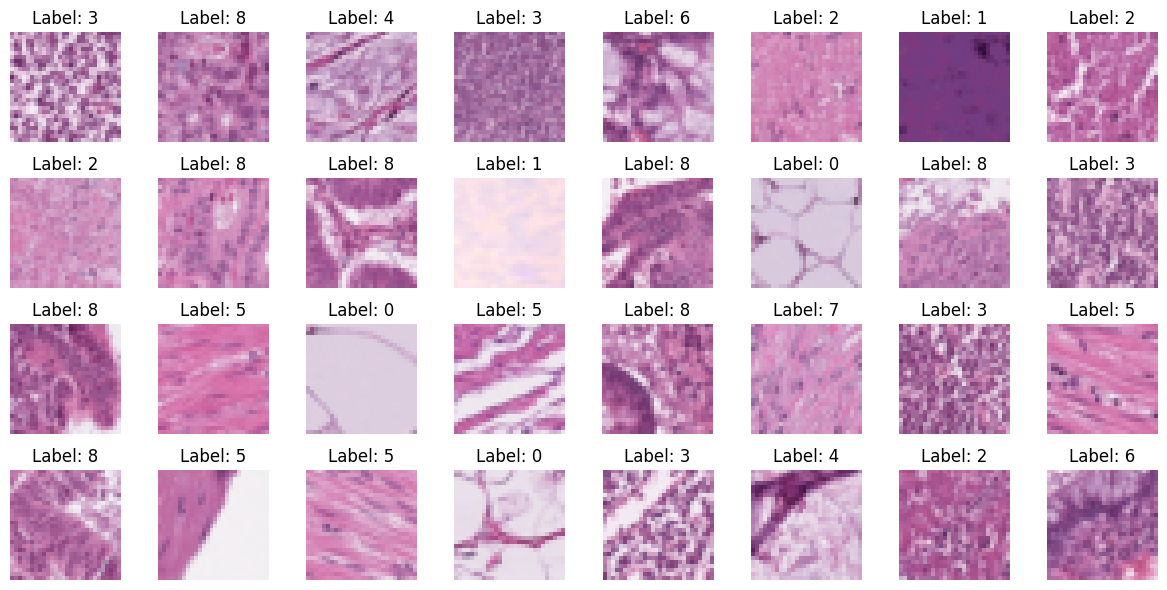

Epoch [01/50] | D Loss: 1.8619 | G Loss: 0.6029
Epoch [02/50] | D Loss: 1.2025 | G Loss: 1.0662
Epoch [03/50] | D Loss: 2.3532 | G Loss: 0.5323
Epoch [04/50] | D Loss: 1.2770 | G Loss: 1.0341
Epoch [05/50] | D Loss: 2.1583 | G Loss: 0.7015
Epoch [06/50] | D Loss: 1.2162 | G Loss: 0.8415
Epoch [07/50] | D Loss: 1.3165 | G Loss: 1.3748
Epoch [08/50] | D Loss: 1.4092 | G Loss: 1.1393
Epoch [09/50] | D Loss: 1.4001 | G Loss: 0.6916
Epoch [10/50] | D Loss: 1.3141 | G Loss: 0.9923


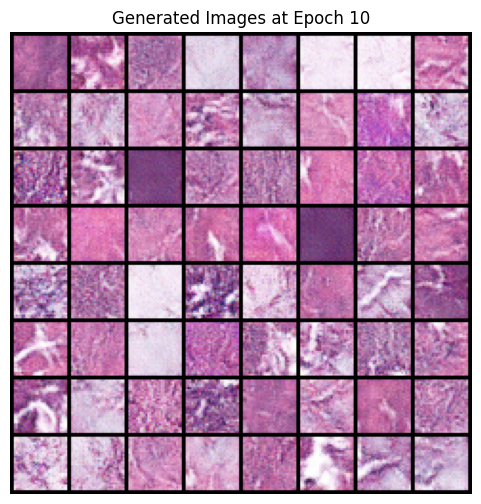

Epoch [11/50] | D Loss: 1.3903 | G Loss: 1.0185
Epoch [12/50] | D Loss: 1.6519 | G Loss: 1.2099
Epoch [13/50] | D Loss: 1.1959 | G Loss: 1.2840
Epoch [14/50] | D Loss: 1.2230 | G Loss: 0.9630
Epoch [15/50] | D Loss: 1.4558 | G Loss: 1.0072
Epoch [16/50] | D Loss: 1.4566 | G Loss: 1.1317
Epoch [17/50] | D Loss: 1.1501 | G Loss: 1.3251
Epoch [18/50] | D Loss: 1.1846 | G Loss: 1.0176
Epoch [19/50] | D Loss: 1.2288 | G Loss: 1.0095
Epoch [20/50] | D Loss: 1.2221 | G Loss: 0.9794


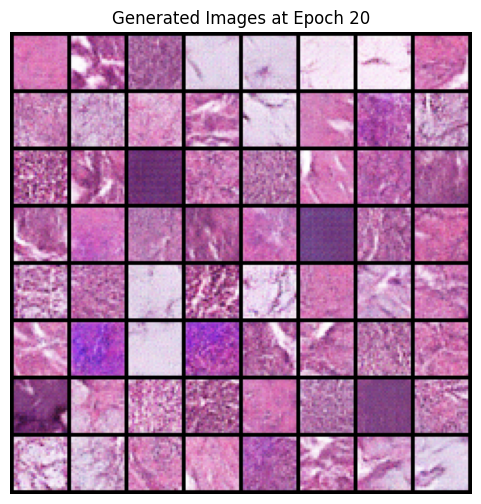

Epoch [21/50] | D Loss: 1.3333 | G Loss: 1.0744
Epoch [22/50] | D Loss: 1.3319 | G Loss: 1.0754
Epoch [23/50] | D Loss: 1.3254 | G Loss: 1.1449
Epoch [24/50] | D Loss: 1.2119 | G Loss: 1.1435
Epoch [25/50] | D Loss: 1.1755 | G Loss: 1.3511
Epoch [26/50] | D Loss: 1.2508 | G Loss: 1.0835
Epoch [27/50] | D Loss: 1.3480 | G Loss: 1.0765
Epoch [28/50] | D Loss: 1.4932 | G Loss: 0.8520
Epoch [29/50] | D Loss: 1.5684 | G Loss: 1.0677
Epoch [30/50] | D Loss: 1.3747 | G Loss: 0.9186


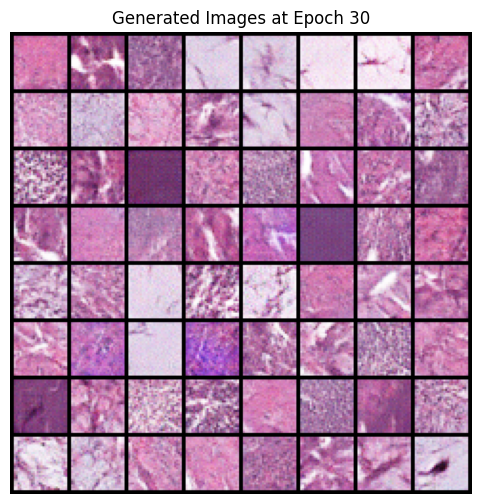

Epoch [31/50] | D Loss: 1.2666 | G Loss: 1.0271
Epoch [32/50] | D Loss: 1.4156 | G Loss: 1.0130
Epoch [33/50] | D Loss: 1.1527 | G Loss: 0.9709
Epoch [34/50] | D Loss: 1.3793 | G Loss: 1.4579
Epoch [35/50] | D Loss: 1.4035 | G Loss: 0.8083
Epoch [36/50] | D Loss: 1.1107 | G Loss: 1.1888
Epoch [37/50] | D Loss: 1.2689 | G Loss: 1.2732
Epoch [38/50] | D Loss: 1.2947 | G Loss: 1.1840
Epoch [39/50] | D Loss: 1.7320 | G Loss: 0.8272
Epoch [40/50] | D Loss: 1.3507 | G Loss: 1.1556


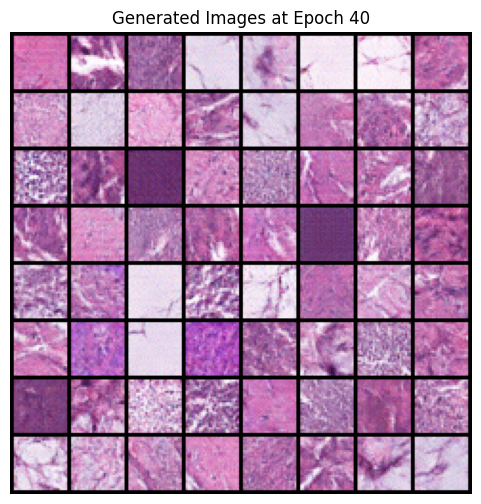

Epoch [41/50] | D Loss: 1.2135 | G Loss: 1.3612
Epoch [42/50] | D Loss: 1.7113 | G Loss: 0.9910
Epoch [43/50] | D Loss: 1.2000 | G Loss: 1.1771
Epoch [44/50] | D Loss: 1.2850 | G Loss: 1.0310
Epoch [45/50] | D Loss: 1.6587 | G Loss: 0.8608
Epoch [46/50] | D Loss: 0.8788 | G Loss: 1.5643
Epoch [47/50] | D Loss: 1.3227 | G Loss: 1.0179
Epoch [48/50] | D Loss: 1.2699 | G Loss: 1.0396
Epoch [49/50] | D Loss: 1.4492 | G Loss: 1.1032
Epoch [50/50] | D Loss: 1.0175 | G Loss: 1.5137


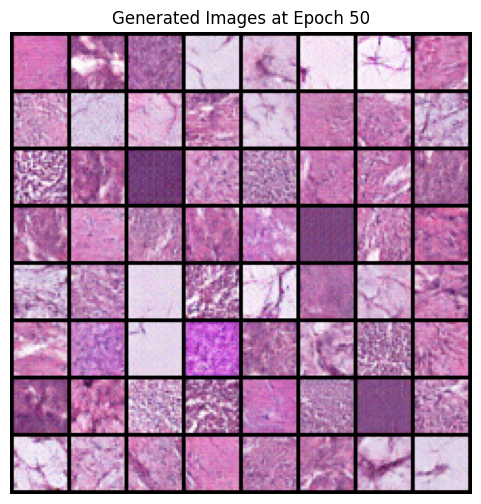

Models saved!


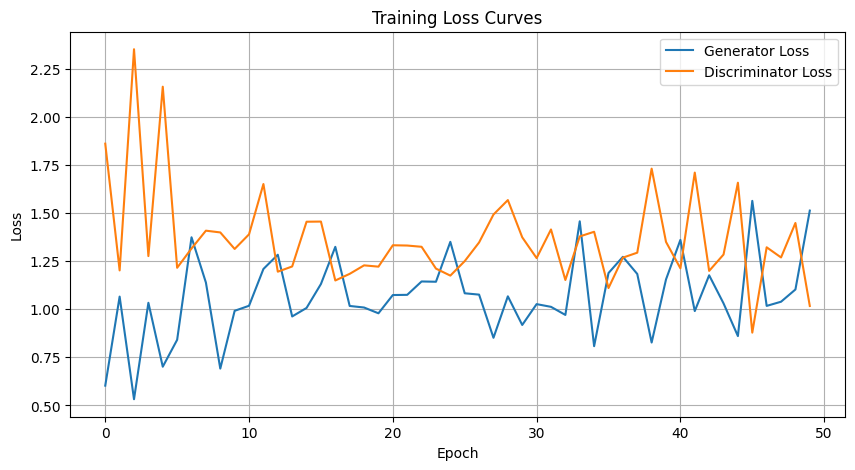

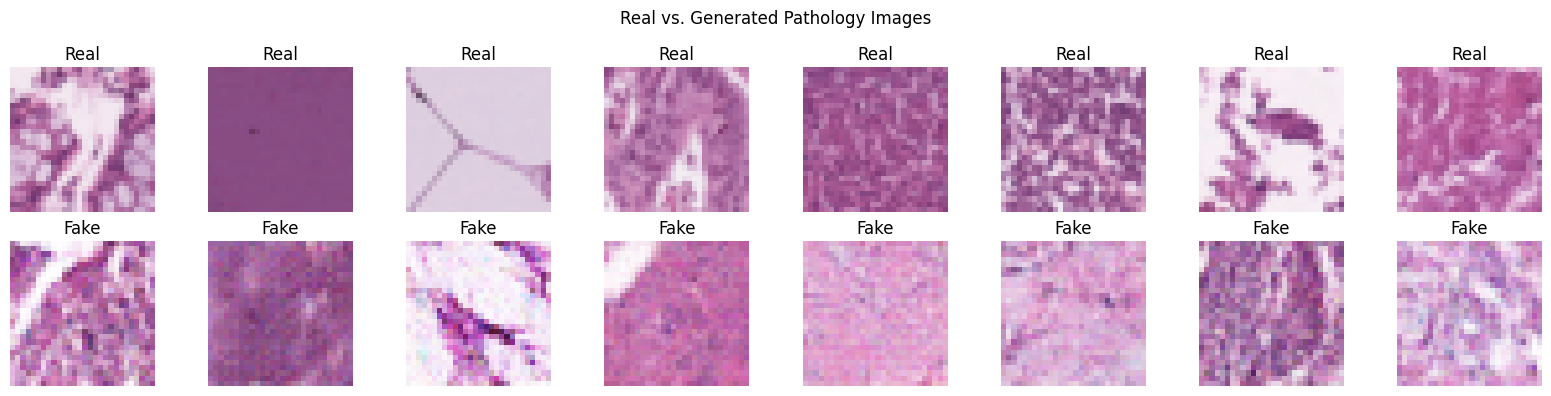

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 100 images in the folder real_pathmnist


FID real_pathmnist : 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Found 100 images in the folder generated_pathmnist


FID generated_pathmnist : 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


FID Score: 128.96036782061896
Average SSIM over 100 samples: 0.1056


In [2]:
# 1. Install necessary libraries
!pip install -q medmnist clean-fid scikit-image

import medmnist
from medmnist import INFO

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from collections import Counter
import torch.nn as nn
import torch.optim as optim
import os
from torchvision.utils import save_image
from cleanfid import fid
from skimage.metrics import structural_similarity as ssim

# Dataset setup
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

print("Image shape:", train_dataset[0][0].shape)
labels = [int(label) for _, label in train_dataset]
counts = Counter(labels)
print("Class distribution:")
for cls, count in counts.items():
    print(f"Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")
plt.tight_layout()
plt.show()

# Generator model
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100

generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

epochs = 50
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)
g_losses = []
d_losses = []

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        batch_size = real.size(0)

        # Add label smoothing and noise injection (optional)
        real_labels = torch.full((batch_size,), 0.9).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        real += 0.05 * torch.randn_like(real)

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = generator(noise)

        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real), real_labels)
        fake_loss = criterion(discriminator(fake.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake), real_labels)
        g_loss.backward()
        optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print(f"Epoch [{epoch+1:02d}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        generator.eval()
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
            fake = (fake + 1) / 2
            grid = torchvision.utils.make_grid(fake, nrow=8, padding=2)
            np_grid = np.transpose(grid.numpy(), (1, 2, 0))
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.imshow(np_grid)
            plt.title(f"Generated Images at Epoch {epoch+1}")
            plt.show()
        generator.train()

# Save models
torch.save(generator.state_dict(), "dcgan_generator_pathmnist.pth")
torch.save(discriminator.state_dict(), "dcgan_discriminator_pathmnist.pth")
print("Models saved!")

# Save final image grid
with torch.no_grad():
    final_fake = generator(fixed_noise).detach().cpu()
    final_fake = (final_fake + 1) / 2
    torchvision.utils.save_image(final_fake, "generated_pathmnist_final.png", nrow=8)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Real vs. Fake side-by-side
real_images, _ = next(iter(train_loader))
real_images = (real_images[:8] + 1) / 2

fixed_noise = torch.randn(8, z_dim, 1, 1).to(device)
generator.eval()
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()
    fake_images = (fake_images + 1) / 2

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(real_images[i], (1, 2, 0)))
    axs[0, i].axis("off")
    axs[0, i].set_title("Real")
    axs[1, i].imshow(np.transpose(fake_images[i], (1, 2, 0)))
    axs[1, i].axis("off")
    axs[1, i].set_title("Fake")
plt.suptitle("Real vs. Generated Pathology Images")
plt.tight_layout()
plt.show()

# Save 100 real and fake images for FID
os.makedirs("real_pathmnist", exist_ok=True)
os.makedirs("generated_pathmnist", exist_ok=True)

for i in range(100):
    img, _ = train_dataset[i]
    save_image((img + 1) / 2, f"real_pathmnist/real_{i}.png")

with torch.no_grad():
    for i in range(100):
        z = torch.randn(1, z_dim, 1, 1).to(device)
        fake_img = generator(z).cpu()
        save_image((fake_img + 1) / 2, f"generated_pathmnist/fake_{i}.png")

# Compute FID Score
score = fid.compute_fid("real_pathmnist", "generated_pathmnist")
print("FID Score:", score)

# Compute SSIM between 100 real and fake image pairs
ssim_scores = []
for i in range(100):
    real_img, _ = train_dataset[i]
    real_np = real_img.permute(1, 2, 0).numpy()
    real_np = np.clip((real_np + 1) / 2, 0, 1)

    z = torch.randn(1, z_dim, 1, 1).to(device)
    with torch.no_grad():
        fake_img = generator(z).cpu()[0]
    fake_np = fake_img.permute(1, 2, 0).numpy()
    fake_np = np.clip((fake_np + 1) / 2, 0, 1)

    score = ssim(real_np, fake_np, channel_axis=-1, data_range=1.0)
    ssim_scores.append(score)

print(f"Average SSIM over 100 samples: {np.mean(ssim_scores):.4f}")


Epoch [1/50] | D Loss: 1.4649 | G Loss: 0.7105
Epoch [2/50] | D Loss: 2.1333 | G Loss: 0.4517
Epoch [3/50] | D Loss: 2.7883 | G Loss: 0.3613
Epoch [4/50] | D Loss: 0.4414 | G Loss: 2.0966
Epoch [5/50] | D Loss: 3.9888 | G Loss: 0.2058
Epoch [6/50] | D Loss: 5.5396 | G Loss: 0.1295
Epoch [7/50] | D Loss: 0.0469 | G Loss: 3.8348
Epoch [8/50] | D Loss: 8.7194 | G Loss: 0.2062
Epoch [9/50] | D Loss: 5.2169 | G Loss: 1.2635
Epoch [10/50] | D Loss: 1.3864 | G Loss: 1.5238


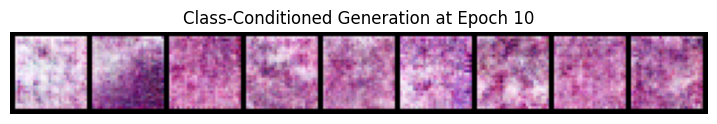

Epoch [11/50] | D Loss: 0.0148 | G Loss: 5.0656
Epoch [12/50] | D Loss: 0.6182 | G Loss: 0.9578
Epoch [13/50] | D Loss: 4.2386 | G Loss: 0.1381
Epoch [14/50] | D Loss: 13.8309 | G Loss: 2.9357
Epoch [15/50] | D Loss: 0.0065 | G Loss: 6.3762
Epoch [16/50] | D Loss: 4.2202 | G Loss: 0.1331
Epoch [17/50] | D Loss: 9.3426 | G Loss: 1.3104
Epoch [18/50] | D Loss: 15.2084 | G Loss: 8.5629
Epoch [19/50] | D Loss: 2.4167 | G Loss: 1.3264
Epoch [20/50] | D Loss: 2.1942 | G Loss: 0.1867


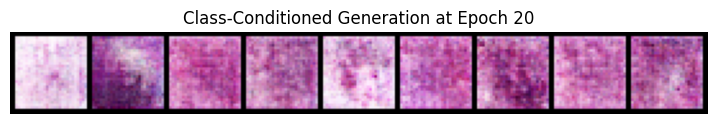

Epoch [21/50] | D Loss: 14.3582 | G Loss: 5.2802
Epoch [22/50] | D Loss: 2.1543 | G Loss: 1.0828
Epoch [23/50] | D Loss: 1.2697 | G Loss: 6.3397
Epoch [24/50] | D Loss: 11.4674 | G Loss: 1.0821
Epoch [25/50] | D Loss: 9.7169 | G Loss: 1.8201
Epoch [26/50] | D Loss: 6.1379 | G Loss: 0.5052
Epoch [27/50] | D Loss: 13.0308 | G Loss: 2.9799
Epoch [28/50] | D Loss: 11.2453 | G Loss: 2.3608
Epoch [29/50] | D Loss: 0.0101 | G Loss: 7.7108
Epoch [30/50] | D Loss: 3.3636 | G Loss: 1.5552


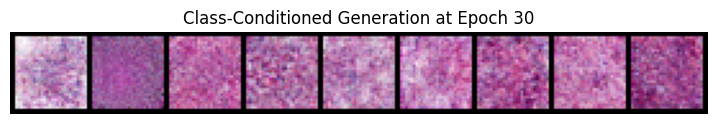

Epoch [31/50] | D Loss: 2.8848 | G Loss: 2.5797
Epoch [32/50] | D Loss: 2.7756 | G Loss: 0.2837
Epoch [33/50] | D Loss: 1.9105 | G Loss: 1.9201
Epoch [34/50] | D Loss: 1.5728 | G Loss: 0.8434
Epoch [35/50] | D Loss: 1.4970 | G Loss: 1.4028
Epoch [36/50] | D Loss: 2.7820 | G Loss: 0.5563
Epoch [37/50] | D Loss: 2.5201 | G Loss: 0.7985
Epoch [38/50] | D Loss: 2.5700 | G Loss: 0.6698
Epoch [39/50] | D Loss: 2.5838 | G Loss: 0.5504
Epoch [40/50] | D Loss: 1.7908 | G Loss: 1.5712


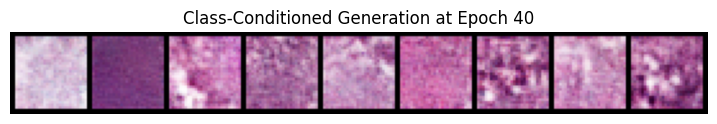

Epoch [41/50] | D Loss: 0.7695 | G Loss: 1.5943
Epoch [42/50] | D Loss: 1.7957 | G Loss: 1.1901
Epoch [43/50] | D Loss: 1.9684 | G Loss: 0.7188
Epoch [44/50] | D Loss: 2.2527 | G Loss: 0.8344
Epoch [45/50] | D Loss: 1.6189 | G Loss: 1.6405
Epoch [46/50] | D Loss: 3.2875 | G Loss: 0.9565
Epoch [47/50] | D Loss: 2.6727 | G Loss: 0.9623
Epoch [48/50] | D Loss: 2.6282 | G Loss: 0.7150
Epoch [49/50] | D Loss: 1.3041 | G Loss: 1.8637
Epoch [50/50] | D Loss: 0.4089 | G Loss: 4.1032


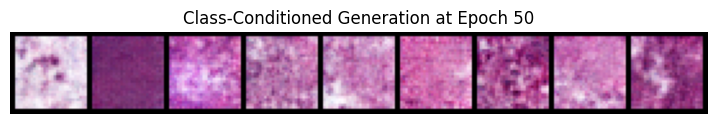

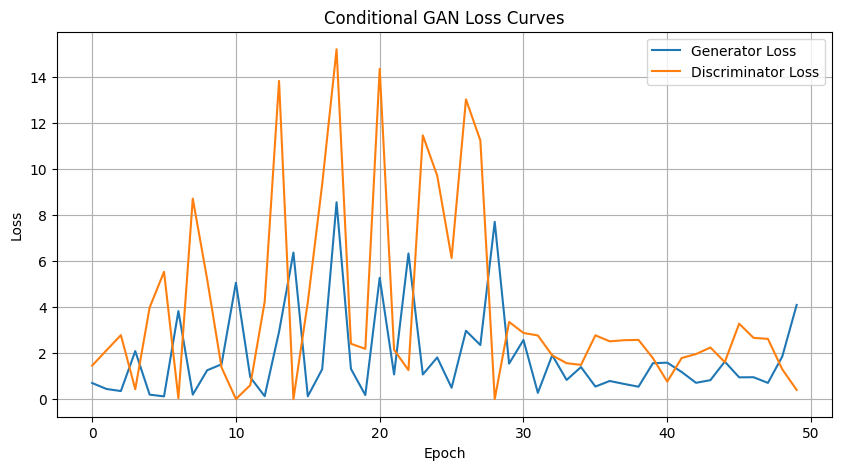

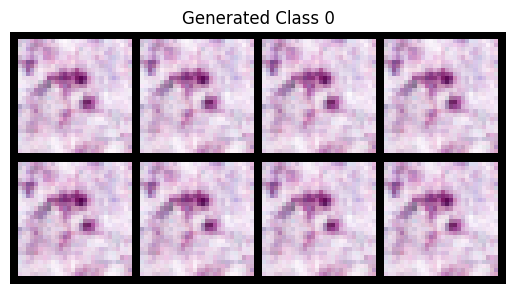

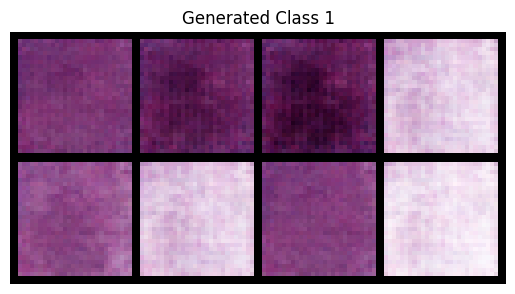

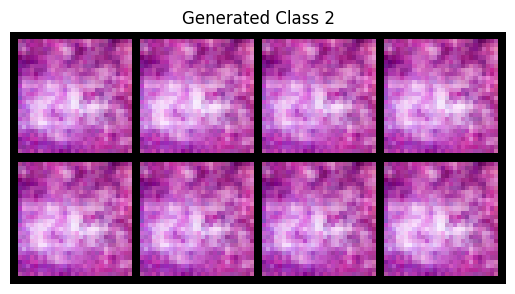

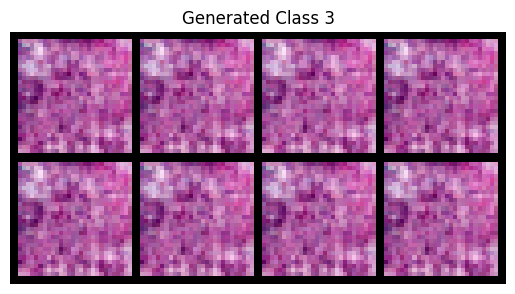

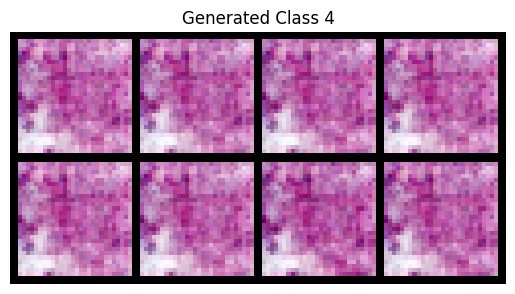

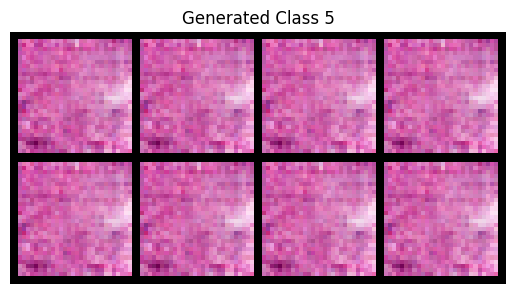

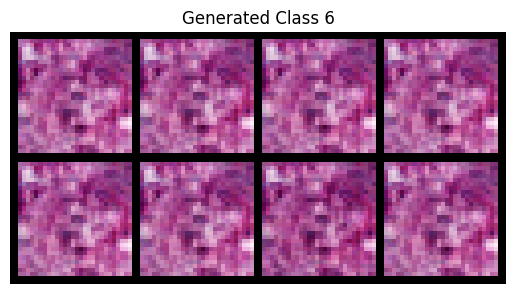

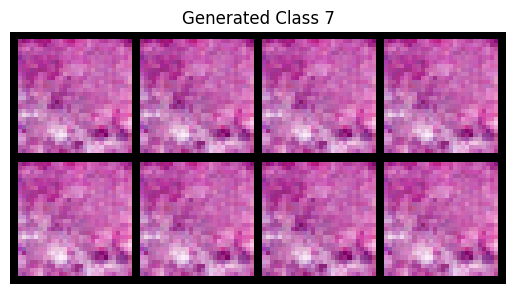

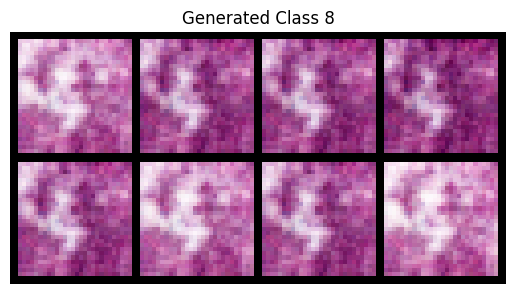

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 100 images in the folder real_cgan


FID real_cgan : 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Found 100 images in the folder fake_cgan


FID fake_cgan : 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


FID Score: 165.25170492031717
Average SSIM over 100 samples: 0.1294


In [1]:
# Install required packages
!pip install -q medmnist clean-fid scikit-image

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from cleanfid import fid
from skimage.metrics import structural_similarity as ssim

import medmnist
from medmnist import INFO

# Dataset
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset info
num_classes = len(info['label'])  # PathMNIST has 9 classes
z_dim = 100
image_size = 28
img_channels = 3

# cGAN Generator
class Generator(nn.Module):
    def __init__(self, z_dim, label_dim, img_channels):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, z_dim)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim * 2, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_embed(labels)
        x = torch.cat([z, label_embed], dim=1)
        x = x.view(x.size(0), -1, 1, 1)
        return self.net(x)

# cGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, label_dim):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, image_size * image_size)
        self.net = nn.Sequential(
            nn.Conv2d(img_channels + 1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_map = self.label_embed(labels).view(-1, 1, image_size, image_size)
        x = torch.cat([x, label_map], dim=1)
        return self.net(x).view(-1)

# Initialize models
G = Generator(z_dim, num_classes, img_channels).to(device)
D = Discriminator(img_channels, num_classes).to(device)

# Optimizers and loss
lr = 0.0002
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
epochs = 50
g_losses = []
d_losses = []
fixed_noise = torch.randn(num_classes, z_dim).to(device)
fixed_labels = torch.arange(0, num_classes).to(device)

for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.squeeze().long().to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)

        D_real = D(real_imgs, labels)
        D_fake = D(fake_imgs.detach(), labels)
        d_loss = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z, labels)
        D_fake = D(fake_imgs, labels)
        g_loss = criterion(D_fake, real_labels)

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate class-wise samples every 10 epochs
    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            fake_imgs = G(fixed_noise, fixed_labels).cpu()
            fake_imgs = (fake_imgs + 1) / 2
            grid = torchvision.utils.make_grid(fake_imgs, nrow=9, normalize=True)
            plt.figure(figsize=(9, 2))
            plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
            plt.axis("off")
            plt.title(f"Class-Conditioned Generation at Epoch {epoch+1}")
            plt.show()
        G.train()

# Save models
torch.save(G.state_dict(), "cgan_generator.pth")
torch.save(D.state_dict(), "cgan_discriminator.pth")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional GAN Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Generate and save per-class samples
os.makedirs("cgan_generated_samples", exist_ok=True)
G.eval()
with torch.no_grad():
    for class_idx in range(num_classes):
        z = torch.randn(8, z_dim).to(device)
        labels = torch.full((8,), class_idx, dtype=torch.long).to(device)
        fake_imgs = G(z, labels).cpu()
        fake_imgs = (fake_imgs + 1) / 2
        grid = torchvision.utils.make_grid(fake_imgs, nrow=4, normalize=True)
        save_image(grid, f"cgan_generated_samples/class_{class_idx}.png")
        plt.figure()
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.title(f"Generated Class {class_idx}")
        plt.show()

# Save 100 real and fake images for FID
os.makedirs("real_cgan", exist_ok=True)
os.makedirs("fake_cgan", exist_ok=True)

for i in range(100):
    img, label = train_dataset[i]
    save_image((img + 1) / 2, f"real_cgan/real_{i}.png")

with torch.no_grad():
    for i in range(100):
        z = torch.randn(1, z_dim).to(device)
        label = torch.randint(0, num_classes, (1,)).to(device)
        fake_img = G(z, label).cpu()
        save_image((fake_img + 1) / 2, f"fake_cgan/fake_{i}.png")

# Compute FID
fid_score = fid.compute_fid("real_cgan", "fake_cgan")
print("FID Score:", fid_score)

# Compute SSIM
ssim_scores = []
for i in range(100):
    real_img, _ = train_dataset[i]
    real_np = real_img.permute(1, 2, 0).numpy()
    real_np = np.clip((real_np + 1) / 2, 0, 1)

    z = torch.randn(1, z_dim).to(device)
    label = torch.randint(0, num_classes, (1,)).to(device)
    with torch.no_grad():
        fake_img = G(z, label).cpu()[0]
    fake_np = fake_img.permute(1, 2, 0).numpy()
    fake_np = np.clip((fake_np + 1) / 2, 0, 1)

    score = ssim(real_np, fake_np, channel_axis=-1, data_range=1.0)
    ssim_scores.append(score)

print(f"Average SSIM over 100 samples: {np.mean(ssim_scores):.4f}")
